https://www.kaggle.com/code/farneetsingh24/ck-facial-emotion-recognition-96-46-accuracy

In [2]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and working with arrays
import cv2 as cv  # For image processing tasks
import os  # For interacting with the operating system, like file paths
import tensorflow as tf  # For building and training neural network models

from tensorflow.keras.preprocessing.image import ImageDataGenerator
  # For real-time data augmentation
from tensorflow.keras.models import load_model  # For loading a saved Keras model
from keras.models import Sequential  # For creating a linear stack of layers in the model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten  # For building model layers
from keras.optimizers import Adam  # For optimization algorithms
from keras.layers import BatchNormalization  # For applying Batch Normalization in neural network layers
from keras.regularizers import l2  # For applying L2 regularization to prevent overfitting
from keras.callbacks import ReduceLROnPlateau, EarlyStopping  # Importing specific callback functions

import warnings  # For handling warnings
import sys  # For interacting with the Python interpreter
if not sys.warnoptions:
    warnings.simplefilter("ignore")  # Ignore simple warnings if not already done
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Ignore deprecation warnings

In [3]:
import shutil

# Define the path to your original dataset and the paths where you want to store your train and test datasets
original_dataset_dir = 'Dataset'
train_dir = 'CK+48_train'
test_dir = 'CK+48_test'

# Create directories for training and testing datasets if they do not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define the split ratio
train_ratio = 0.8

# Loop through each emotion category in the original dataset
for emotion in os.listdir(original_dataset_dir):
    emotion_dir = os.path.join(original_dataset_dir, emotion)
    if os.path.isdir(emotion_dir):
        # Get a list of all the image filenames in the emotion category
        images = [f for f in os.listdir(emotion_dir) if os.path.isfile(os.path.join(emotion_dir, f))]
        
        # Randomly shuffle the list of image filenames
        np.random.shuffle(images)
        
        # Split the list of image filenames into training and testing sets
        train_size = int(len(images) * train_ratio)
        train_images = images[:train_size]
        test_images = images[train_size:]
        
        # Create directories for the emotion category in the train and test datasets
        train_emotion_dir = os.path.join(train_dir, emotion)
        test_emotion_dir = os.path.join(test_dir, emotion)
        os.makedirs(train_emotion_dir, exist_ok=True)
        os.makedirs(test_emotion_dir, exist_ok=True)
        
        # Copy the images into the corresponding directories
        for image in train_images:
            shutil.copy(os.path.join(emotion_dir, image), os.path.join(train_emotion_dir, image))
        for image in test_images:
            shutil.copy(os.path.join(emotion_dir, image), os.path.join(test_emotion_dir, image))

print("Dataset splitting complete")

Dataset splitting complete


In [4]:
import cv2

# Load the image
img = cv2.imread('CK+48_train/disgust/S098_003_00000013.png')

# Get dimensions
# height, width, channels = img.shape
# print(f'Dimensions: {width}x{height}')
img.shape

(48, 48, 3)

In [5]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values (normalization)
    rotation_range=15,  # Random rotation in the range of 15 degrees
    width_shift_range=0.15,  # Random horizontal shifts (15% of total width)
    height_shift_range=0.15,  # Random vertical shifts (15% of total height)
    shear_range=0.15,  # Random shearing transformations
    zoom_range=0.15,  # Random zoom range
    horizontal_flip=True,  # Randomly flip inputs horizontally
)

# Load images from the directory and apply the defined transformations
fer_training_data = train_data_generator.flow_from_directory(
    'CK+48_train',  # Path to the training data
    target_size=(48, 48),  # Resize images to 48x48
    batch_size=64,  # Number of images to yield per batch
    color_mode='grayscale',  # Load images in grayscale
    class_mode='categorical'  # Labels will be returned in categorical format
)

fer_training_data

Found 934 images belonging to 7 classes.


In [6]:
# Initialize an ImageDataGenerator for test data with rescaling
# Rescales images by dividing pixel values by 255 (normalization)
test_data_generator = ImageDataGenerator(rescale=1./255)

# Creates a data generator for the test dataset
# flow_from_directory method loads images from a directory,
# in this case, '/kaggle/working/CK+48_test'
fer_test_data = test_data_generator.flow_from_directory(
    'CK+48_test',  # Directory path for test images
    target_size = (48, 48),  # Resizes images to 48x48 pixels
    batch_size = 64,  # Number of images to yield per batch
    color_mode = 'grayscale',  # Specifies that images are in grayscale
    class_mode = 'categorical'  # Images are classified categorically
)

# fer_test_data is now a generator that yields batches of test images and their labels
fer_test_data

Found 349 images belonging to 7 classes.


In [7]:
# Importing the optimizers module from TensorFlow's Keras library
from tensorflow.keras import optimizers

# Initializing a list of optimizers with specific configurations
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(
        Conv2D(
            filters=512,
            kernel_size=(5,5),
            input_shape=(48, 48, 1),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
model.add(BatchNormalization(name='batchnorm_1'))
model.add(
        Conv2D(
            filters=256,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
model.add(BatchNormalization(name='batchnorm_2'))
    
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
model.add(Dropout(0.25, name='dropout_1'))

model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
model.add(BatchNormalization(name='batchnorm_3'))
model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
model.add(BatchNormalization(name='batchnorm_4'))
    
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
model.add(Dropout(0.25, name='dropout_2'))

model.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
model.add(BatchNormalization(name='batchnorm_5'))
model.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
model.add(BatchNormalization(name='batchnorm_6'))
    
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
model.add(Dropout(0.25, name='dropout_3'))

model.add(Flatten(name='flatten'))
        
model.add(
        Dense(
            256,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
model.add(BatchNormalization(name='batchnorm_7'))
    
model.add(Dropout(0.25, name='dropout_4'))
    
model.add(
        Dense(
            7,
            activation='softmax',
            name='out_layer'
        )
    )
    
model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 512)    │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 256)    │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,937,159 (37.91 MB)

 Trainable params: 9,933,063 (37.89 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [9]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [10]:
batch_size = 64
history = model.fit(
    fer_training_data,
    epochs=60, 
    validation_data=fer_test_data,
    batch_size = 64,
    callbacks=callbacks,
)

Epoch 1/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step - accuracy: 0.2855 - loss: 2.7183 - val_accuracy: 0.2149 - val_loss: 118.7680 - learning_rate: 0.0010
Epoch 2/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 86s 6s/step - accuracy: 0.4604 - loss: 1.4702 - val_accuracy: 0.3009 - val_loss: 42.3947 - learning_rate: 0.0010
Epoch 3/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 86s 6s/step - accuracy: 0.5785 - loss: 1.1774 - val_accuracy: 0.3868 - val_loss: 8.8338 - learning_rate: 0.0010
Epoch 4/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step - accuracy: 0.6353 - loss: 1.0032 - val_accuracy: 0.4728 - val_loss: 3.8474 - learning_rate: 0.0010
Epoch 5/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step - accuracy: 0.7105 - loss: 0.8141 - val_accuracy: 0.5845 - val_loss: 1.7204 - learning_rate: 0.0010
Epoch 6/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step - accuracy: 0.7038 - loss: 0.7522 - val_accuracy: 0.6103 - val_loss: 1.7660 - learning_rate: 0.0010
Epoch 7/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step - accuracy: 0.7537 - loss: 0.7126 - val_accurac

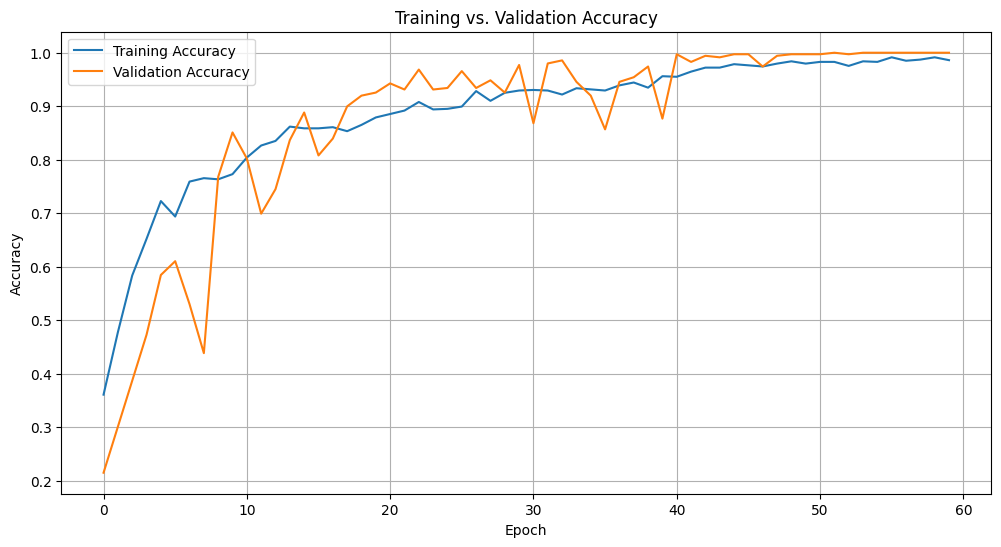

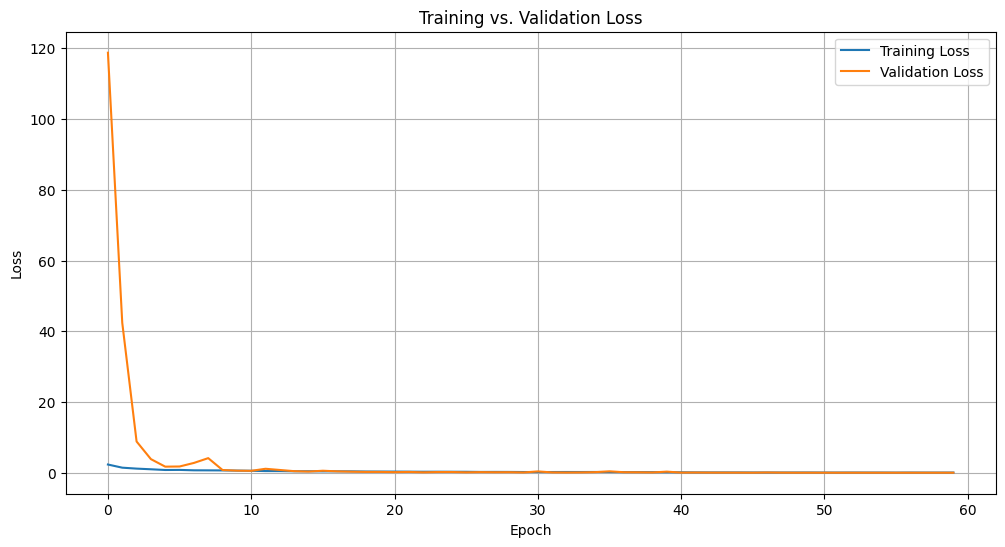

In [11]:
import matplotlib.pyplot as plt

# Training vs. Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Training vs. Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
model.save('model2.h5')
